In [1]:
# 1
!nvidia-smi
import lightgbm as lgb
print('LightGBM version:', lgb.__version__)

Wed Jul 23 08:30:33 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.64.04              Driver Version: 577.00         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 Ti     On  |   00000000:01:00.0  On |                  N/A |
| 30%   36C    P0             27W /  285W |    2186MiB /  12282MiB |      4%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
# 2
import pandas as pd
import numpy as np
from category_encoders import TargetEncoder

# Common preprocessing & latest features (exp_04)
def preprocess(df):
    # -------- Feature: Deck / Side (from Cabin)
    df['Deck'] = df['Cabin'].str[0].fillna('U').astype('category')
    df['Side'] = df['Cabin'].str[-1] \
        .map(lambda x: 'port' if x in ['P','L'] else 'starboard') \
        .fillna('U').astype('category')

    # -------- Feature: Group (family / party)
    df['Group'] = df['PassengerId'].str.split('_').str[0]
    df['GroupSize'] = df.groupby('Group')['PassengerId'].transform('count')
    df['IsSolo'] = (df['GroupSize'] == 1).astype(int)

    # -------- Feature: Spending features
    spend_cols = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
    df[spend_cols] = df[spend_cols].fillna(0)
    df['TotalSpending'] = df[spend_cols].sum(axis=1)
    df['LogTotalSpending'] = np.log1p(df['TotalSpending'])
    dup_bins = pd.qcut(df['TotalSpending'], q=4, labels=False, duplicates='drop')
    df['SpendBin'] = dup_bins.fillna(0).astype(int)

    # -------- Feature: Age
    df['Age'] = df['Age'].fillna(df['Age'].median())
    df['AgeBin'] = pd.cut(
        df['Age'],
        bins=[0,18,40,60,80],
        labels=['Child','YoungAdult','Adult','Senior']
    ).astype('category')

    # -------- Feature: Name / Title extraction（正規表現版）
    df['Name'] = df['Name'].fillna('').astype(str)
    # カンマ以降、ピリオド手前の文字列を「Title」として抜き出す
    title = df['Name'].str.extract(r',\s*([^\.]+)\.', expand=False).fillna('Other')
    # 代表的なタイトルだけ残し、その他は Other に
    common_titles = ['Mr','Mrs','Miss','Master']
    df['Title'] = title.where(title.isin(common_titles), 'Other').astype('category')

    # -------- Feature: Categorical fill
    df['HomePlanet']  = df['HomePlanet'].fillna('Unknown').astype('category')
    df['Destination'] = df['Destination'].fillna('Unknown').astype('category')
    df['VIP']         = df['VIP'].fillna(False).astype(int)
    df['CryoSleep']   = df['CryoSleep'].fillna(False).astype(int)

    return df


# Load data
train = pd.read_csv('../data/train.csv')
test  = pd.read_csv('../data/test.csv')
train = preprocess(train)
test  = preprocess(test)
TARGET = 'Transported'
features = [c for c in train.columns if c not in ['PassengerId', TARGET]]

/tmp/ipykernel_6813/2549081551.py:46: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['VIP']         = df['VIP'].fillna(False).astype(int)
/tmp/ipykernel_6813/2549081551.py:47: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['CryoSleep']   = df['CryoSleep'].fillna(False).astype(int)
/tmp/ipykernel_6813/2549081551.py:46: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_

In [8]:
# 2.1 EDA: HTML 表示によるデータ概要 EDA: HTML 表示によるデータ概要
from IPython.display import display, HTML
import io

# Train Info をバッファにキャプチャ
buf = io.StringIO()
train.info(buf=buf)
info_str = buf.getvalue()
display(HTML(f'<pre>{info_str}</pre>'))

# 全体統計量 (describe)
display(train.describe(include='all'))

# 欠損値一覧
missing = train.isnull().sum().sort_values(ascending=False)
missing_df = missing[missing > 0].to_frame('missing_count')
display(HTML(missing_df.to_html()))

# カテゴリ値の分布を HTML テーブルで表示
for col in ['HomePlanet','Destination','Deck','Side','VIP','CryoSleep']:
    vc = train[col].value_counts().to_frame('count')
    vc.index.name = col
    # 全ての行を表示
    html = vc.to_html(max_rows=None)
    display(HTML(html))

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Deck,Side,Group,GroupSize,IsSolo,TotalSpending,LogTotalSpending,SpendBin,AgeBin,Title
count,8693,8693,8693.000000,8494,8693,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,...,8693,8693,8693,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8515,8693
unique,8693,4,NaN,6560,4,NaN,NaN,NaN,NaN,NaN,...,9,2,6217,NaN,NaN,NaN,NaN,NaN,4,1
top,9280_02,Earth,NaN,G/734/S,TRAPPIST-1e,NaN,NaN,NaN,NaN,NaN,...,F,starboard,9081,NaN,NaN,NaN,NaN,NaN,YoungAdult,Other
freq,1,4602,NaN,8,5915,NaN,NaN,NaN,NaN,NaN,...,2794,4487,8,NaN,NaN,NaN,NaN,NaN,5097,8693
mean,NaN,NaN,0.349362,NaN,NaN,28.790291,0.022892,220.009318,448.434027,169.572300,...,NaN,NaN,NaN,2.035546,0.552744,1440.866329,4.253005,0.749914,NaN,NaN
std,NaN,NaN,0.476796,NaN,NaN,14.341404,0.149568,660.519050,1595.790627,598.007164,...,NaN,NaN,NaN,1.596347,0.497239,2803.045694,3.689350,0.829195,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN,20.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN,27.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,1.000000,1.000000,716.000000,6.575076,0.000000,NaN,NaN
75%,NaN,NaN,1.000000,NaN,NaN,37.000000,0.000000,41.000000,61.000000,22.000000,...,NaN,NaN,NaN,3.000000,1.000000,1441.000000,7.273786,1.000000,NaN,NaN


,missing_count
Cabin,199
AgeBin,178


,count
HomePlanet,
Earth,4602
Europa,2131
Mars,1759
Unknown,201


,count
Destination,
TRAPPIST-1e,5915
55 Cancri e,1800
PSO J318.5-22,796
Unknown,182


,count
Deck,
F,2794
G,2559
E,876
B,779
C,747
D,478
A,256
U,199
T,5


,count
Side,
starboard,4487
port,4206


,count
VIP,
0,8494
1,199


,count
CryoSleep,
0,5656
1,3037


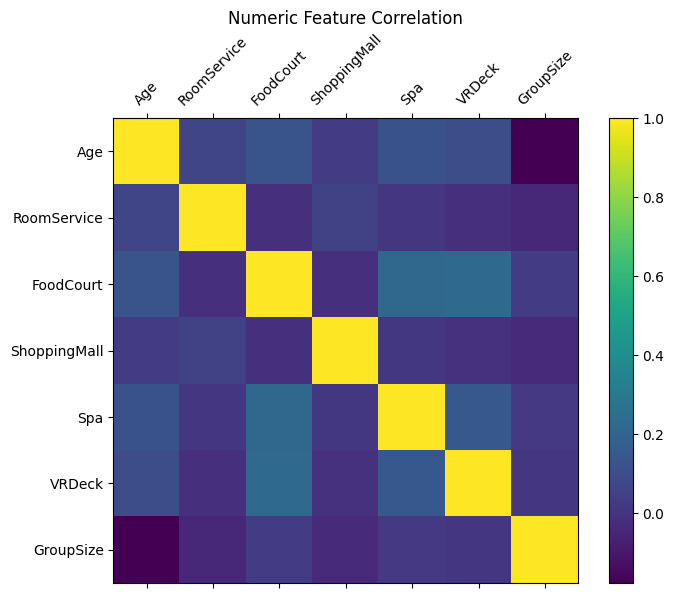

In [9]:
# 2.2 数値特徴量の相関確認 数値特徴量の相関確認
import matplotlib.pyplot as plt
num_cols = ['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','GroupSize']
corr = train[num_cols].corr()
plt.figure(figsize=(8,6))
plt.matshow(corr, fignum=1)
plt.xticks(range(len(num_cols)), num_cols, rotation=45)
plt.yticks(range(len(num_cols)), num_cols)
plt.colorbar()
plt.title('Numeric Feature Correlation')
plt.show()

,NotTransported,Transported
HomePlanet,,
Earth,0.576054,0.423946
Europa,0.341154,0.658846
Mars,0.476976,0.523024
Unknown,0.487562,0.512438


,NotTransported,Transported
Destination,,
55 Cancri e,0.390000,0.610000
PSO J318.5-22,0.496231,0.503769
TRAPPIST-1e,0.528825,0.471175
Unknown,0.494505,0.505495


,NotTransported,Transported
Deck,,
A,0.503906,0.496094
B,0.265725,0.734275
C,0.319946,0.680054
D,0.566946,0.433054
E,0.642694,0.357306
F,0.560129,0.439871
G,0.483783,0.516217
T,0.800000,0.200000
U,0.497487,0.502513


,NotTransported,Transported
Side,,
port,0.548740,0.451260
starboard,0.447292,0.552708


,NotTransported,Transported
VIP,,
0,0.493525,0.506475
1,0.618090,0.381910


,NotTransported,Transported
CryoSleep,,
0,0.664958,0.335042
1,0.182417,0.817583


/tmp/ipykernel_6813/3984742618.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  proc = train.groupby(col)[TARGET].mean().sort_values()


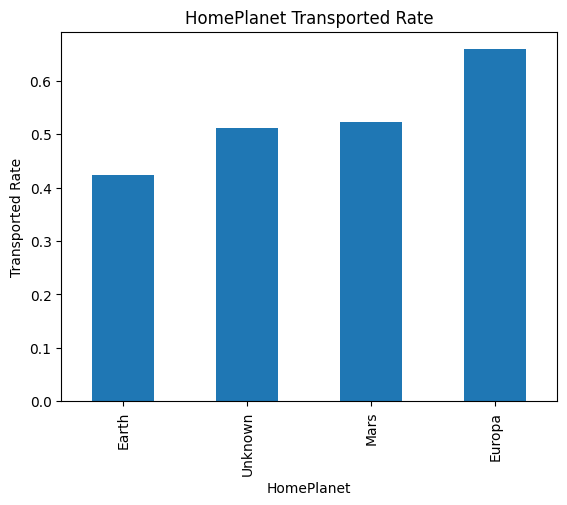

/tmp/ipykernel_6813/3984742618.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  proc = train.groupby(col)[TARGET].mean().sort_values()


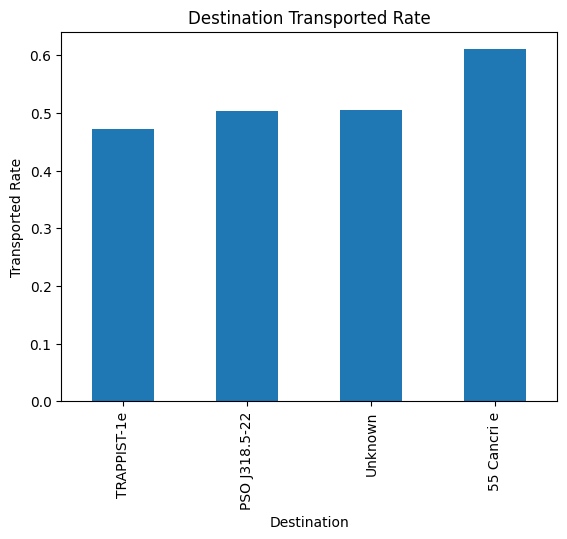

/tmp/ipykernel_6813/3984742618.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  proc = train.groupby(col)[TARGET].mean().sort_values()


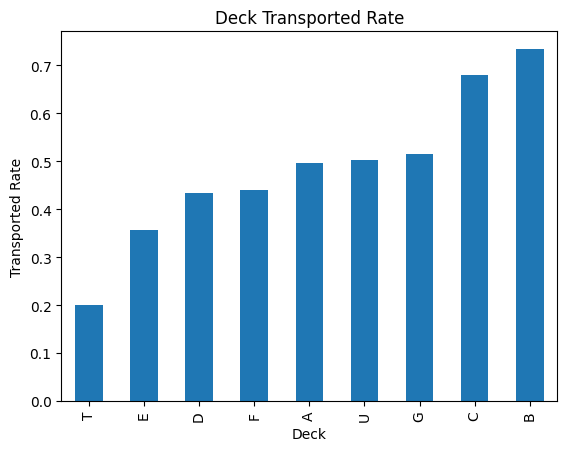

/tmp/ipykernel_6813/3984742618.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  proc = train.groupby(col)[TARGET].mean().sort_values()


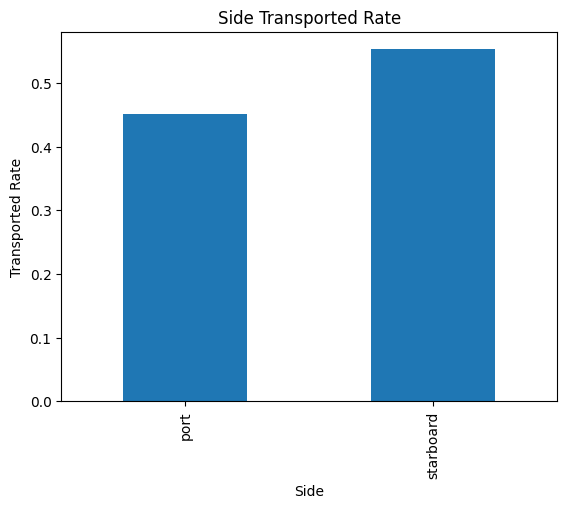

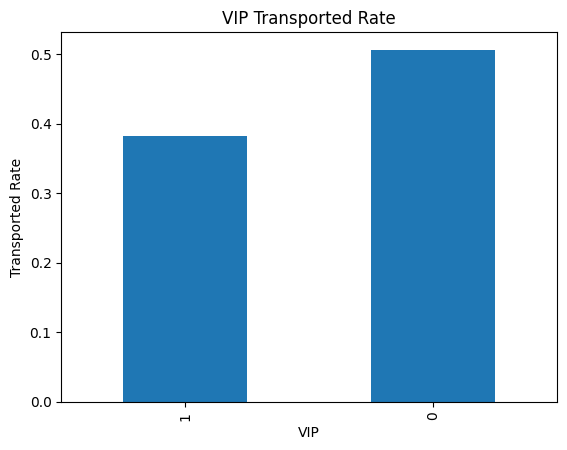

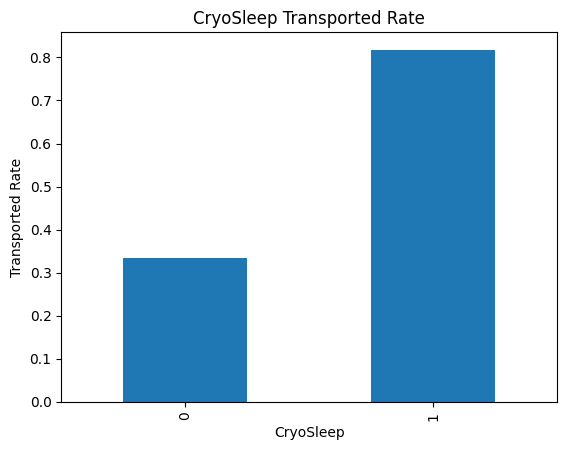

In [10]:
# 2.3 目的変数 (Transported) 別のカテゴリ特徴量分析
from IPython.display import display, HTML
# カテゴリごとの Transported 比率をテーブル化
for col in ['HomePlanet','Destination','Deck','Side','VIP','CryoSleep']:
    ct = pd.crosstab(train[col], train[TARGET], normalize='index')
    ct.columns = ['NotTransported','Transported']
    display(HTML(f'<h4>{col} vs Transported rate</h4>' + ct.to_html()))

# 棒グラフでも可視化
for col in ['HomePlanet','Destination','Deck','Side','VIP','CryoSleep']:
    proc = train.groupby(col)[TARGET].mean().sort_values()
    proc.plot(kind='bar', title=f'{col} Transported Rate')
    plt.ylabel('Transported Rate')
    plt.show()

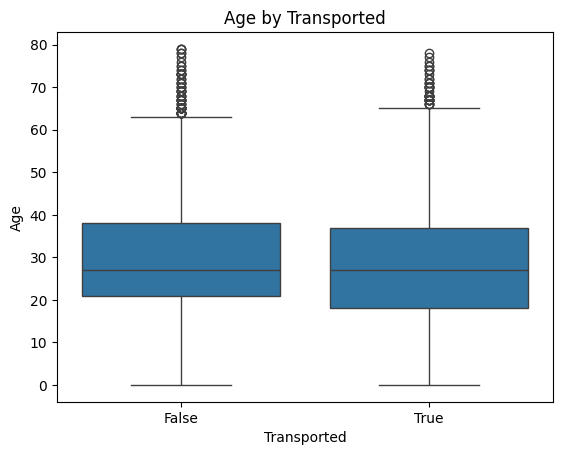

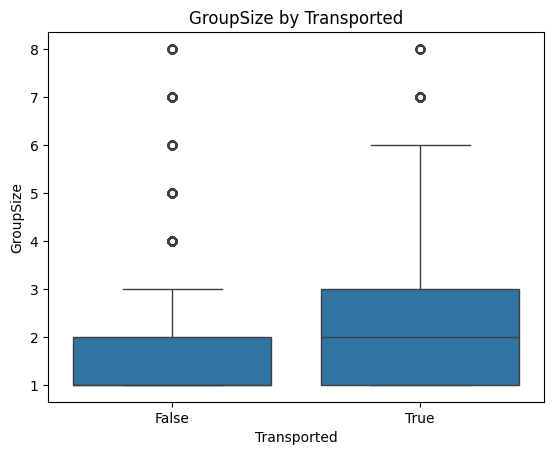

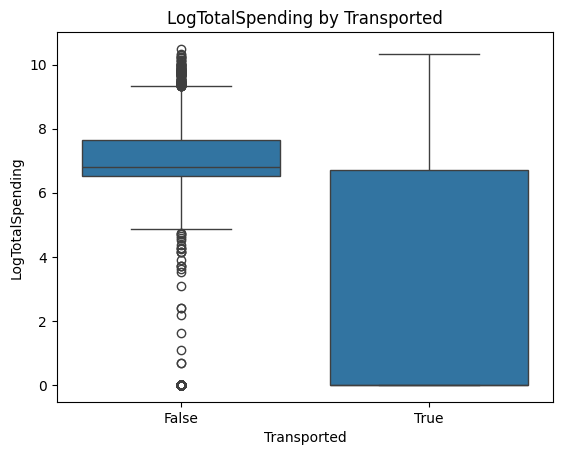

In [11]:
# 2.4 数値特徴量の分布比較
# Total Spending 特徴量作成
import seaborn as sns
train['TotalSpending'] = train[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].sum(axis=1)
train['LogTotalSpending'] = np.log1p(train['TotalSpending'])

# Age, GroupSize, LogTotalSpending の箱ひげ図
for col in ['Age','GroupSize','LogTotalSpending']:
    plt.figure()
    sns.boxplot(x=train[TARGET], y=train[col])
    plt.title(f'{col} by Transported')
    plt.show()

In [13]:
# 2.6 エンコーディング＆特徴量整形
from category_encoders import TargetEncoder
# (1) Target Encoding for HomePlanet, Destination
target_cols = ['HomePlanet','Destination']
te = TargetEncoder(cols=target_cols, smoothing=0.3)
train[target_cols] = te.fit_transform(train[target_cols], train[TARGET])
test[target_cols]  = te.transform(test[target_cols])

# (2) One-Hot Encoding for categorical cols
ohe_cols = ['Deck','Side','Title','AgeBin','SpendBin','Deck_Side','AgeSpend']
train = pd.get_dummies(train, columns=ohe_cols, drop_first=True)
test  = pd.get_dummies(test,  columns=ohe_cols, drop_first=True)
# Align train/test to have same columns
test = test.reindex(columns=train.columns, fill_value=0)

# (3) GroupRate and SpendOutlier should already be in train/test
#    If needed, cap GroupSize: train['GroupSize'] = train['GroupSize'].clip(upper=4)

# Update feature list
def get_feature_list(df):
    excluded = ['PassengerId', TARGET]
    return [c for c in df.columns if c not in excluded]
features = get_feature_list(train)
print('Number of features:', len(features))

Number of features: 61


In [14]:
# 3
from sklearn.model_selection import StratifiedGroupKFold

# StratifiedGroupKFold の準備
sgkf = StratifiedGroupKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

# グループ情報（同じプレフィックスを持つ PassengerId）
groups = train['PassengerId'].str.split('_').str[0].astype(int)

# OOF とテスト予測用の配列を初期化
oof_preds  = np.zeros(len(train))
test_preds = np.zeros(len(test))


In [22]:
# 4 モデル学習＆MLflowログ（CPUモード版） ── Fold 毎に Target Encoding & GroupRate 計算
import mlflow
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.metrics import accuracy_score
from category_encoders import TargetEncoder

mlflow.set_experiment('exp_06_lgbm_sgk')

# Optuna で探索した最適パラメータを反映
CONFIG = {
    'objective': 'binary',
    'metric': 'binary_error',
    'learning_rate': 0.09725044733444409,
    'num_leaves': 29,
    'n_estimators': 1000,
    'random_state': 42,
    'n_jobs': -1,
    'feature_fraction': 0.8857126219094053,
    'bagging_fraction': 0.7444780973650492,
    'bagging_freq': 5,
    'min_child_samples': 89,
    'lambda_l1': 0.037103541204519565,
    'lambda_l2': 7.157639256308277e-06,
}

with mlflow.start_run(run_name='exp_06_lgbm_sgk'):
    # OOF & テスト予測配列
    oof_preds  = np.zeros(len(train))
    test_preds = np.zeros(len(test))

    for fold, (tr_idx, val_idx) in enumerate(sgkf.split(train, train[TARGET], groups)):
        print(f'Fold {fold}')

        # データをコピー
        X_tr, X_val = train.iloc[tr_idx].copy(), train.iloc[val_idx].copy()
        y_tr = X_tr[TARGET]

        # (1) Fold 内で Target Encoding
        te = TargetEncoder(cols=['HomePlanet', 'Destination'], smoothing=0.3)
        X_tr[['HomePlanet','Destination']] = te.fit_transform(
            X_tr[['HomePlanet','Destination']], y_tr
        )
        X_val[['HomePlanet','Destination']] = te.transform(
            X_val[['HomePlanet','Destination']]
        )

        # (2) Fold 内で GroupRate 計算
        grp_rate = X_tr.groupby('Group')[TARGET].mean().to_dict()
        X_tr['GroupRate'] = X_tr['Group'].map(grp_rate)
        X_val['GroupRate'] = X_val['Group'].map(grp_rate).fillna(y_tr.mean())

        # (3) LightGBM 用 Dataset 作成
        dtrain = lgb.Dataset(
            X_tr[features], label=y_tr, categorical_feature='auto'
        )
        dval = lgb.Dataset(
            X_val[features], label=X_val[TARGET], categorical_feature='auto'
        )

        # (4) モデル訓練
        model = lgb.train(
            CONFIG,
            dtrain,
            valid_sets=[dval],
            callbacks=[
                early_stopping(stopping_rounds=50),
                log_evaluation(period=0),
            ]
        )

        # (5) OOF & テスト予測
        oof_preds[val_idx] = (model.predict(X_val[features]) > 0.5).astype(int)
        test_preds       += model.predict(test[features]) / sgkf.n_splits

    # (6) CV スコア計算＆ログ
    cv_acc = accuracy_score(train[TARGET], oof_preds)
    mlflow.log_metric('cv_acc', cv_acc)
    print(f'[exp_06_lgbm_sgk] cv_acc: {cv_acc:.4f}')


Fold 0
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 3539, number of negative: 3457
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001559 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2818
[LightGBM] [Info] Number of data points in the train set: 6996, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505860 -> initscore=0.023443
[LightGBM] [Info] Start training from score 0.023443
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

/tmp/ipykernel_6813/1158510303.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp_rate = X_tr.groupby('Group')[TARGET].mean().to_dict()


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[90]	valid_0's binary_error: 0.232764
Fold 1
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 3498, number of negative: 3441
[LightGBM] [Info] Au

/tmp/ipykernel_6813/1158510303.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp_rate = X_tr.groupby('Group')[TARGET].mean().to_dict()


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[70]	valid_0's binary_error: 0.190422
Fold 2
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 3463, number of negative: 3479
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000565 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2777
[LightGBM] [Info] Number of data points in the train set: 6942, number of used features: 54
[LightGBM] [Info] [binary:BoostF

/tmp/ipykernel_6813/1158510303.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp_rate = X_tr.groupby('Group')[TARGET].mean().to_dict()


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_6813/1158510303.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp_rate = X_tr.groupby('Group')[TARGET].mean().to_dict()


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 3543, number of negative: 3449
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028013 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2821
[LightGBM] [Info] Number of data points in the train set: 6992, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506722 -> initscore=0.026889
[LightGBM] [Info] Start training from score 0.026889
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

/tmp/ipykernel_6813/1158510303.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp_rate = X_tr.groupby('Group')[TARGET].mean().to_dict()


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 3469, number of negative: 3434
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2784
[LightGBM] [Info] Number of data points in the train set: 6903, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502535 -> initscore=0.010141
[LightGBM] [Info] Start training from score 0.010141
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

Fold 0 acc: 0.7672
Fold 1 acc: 0.8096
Fold 2 acc: 0.8087
Fold 3 acc: 0.8066
Fold 4 acc: 0.7866


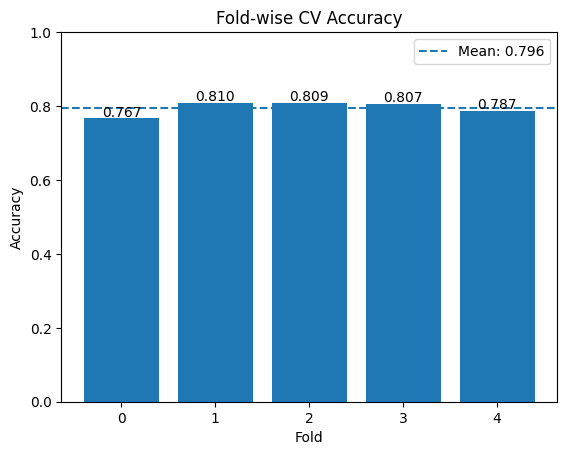

In [23]:
# 5 Fold-wise 可視化
import matplotlib.pyplot as plt
fold_scores = []
for fold, (_, val_idx) in enumerate(sgkf.split(train, train[TARGET], groups)):
    acc = accuracy_score(train.iloc[val_idx][TARGET], oof_preds[val_idx])
    fold_scores.append(acc)
    print(f'Fold {fold} acc: {acc:.4f}')
mean_score = np.mean(fold_scores)
plt.bar(range(len(fold_scores)), fold_scores)
plt.axhline(mean_score, linestyle='--', label=f'Mean: {mean_score:.3f}')
for i, s in enumerate(fold_scores): plt.text(i, s+0.005, f'{s:.3f}', ha='center')
plt.title('Fold-wise CV Accuracy')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.legend()
plt.show()


In [24]:
# 6 最適閾値探索
from sklearn.metrics import accuracy_score
probs = np.zeros(len(train))
for fold, (tr_idx, val_idx) in enumerate(sgkf.split(train, train[TARGET], groups)):
    tr_data = lgb.Dataset(train.iloc[tr_idx][features], label=train.iloc[tr_idx][TARGET], categorical_feature='auto')
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=train.iloc[val_idx][TARGET], categorical_feature='auto')
    model_tmp = lgb.train(CONFIG, tr_data, valid_sets=[val_data], callbacks=[early_stopping(50), log_evaluation(period=0)])
    probs[val_idx] = model_tmp.predict(train.iloc[val_idx][features])
best_acc, best_thresh = 0, 0.5
for t in np.linspace(0.3, 0.7, 41):
    acc = accuracy_score(train[TARGET], (probs>t).astype(int))
    if acc > best_acc:
        best_acc, best_thresh = acc, t
print(f'Best threshold: {best_thresh:.2f}, CV acc: {best_acc:.4f}')


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 3539, number of negative: 3457
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2818
[LightGBM] [Info] Number of data points in the train set: 6996, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505860 -> initscore=0.023443
[LightGBM] [Info] Start training from score 0.023443
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

In [28]:
# 7 Pseudo-Labeling ── 擬似ラベルを追加して再学習
from sklearn.metrics import accuracy_score

# 1) テストセットの予測確率を取得
test_probs = test_preds.copy()  # セル4実行後の test_preds

# 2) 高信頼度サンプルを抽出
high_conf_mask = (test_probs > 0.99) | (test_probs < 0.01)

# 3) 擬似データを作成
pseudo_X = test.loc[high_conf_mask, features]
pseudo_y = (test_probs[high_conf_mask] > 0.5).astype(int)

# 4) テスト側の group 情報を取ってくる
#    PassengerId のプレフィックスを数値化
groups_test = (
    test.loc[high_conf_mask, 'PassengerId']
        .str.split('_').str[0]
        .astype(int)
        .values
)

# 5) train + pseudo のグループ配列を作る
groups_all = np.concatenate([groups.values, groups_test])

# 6) CV 用データも合わせて結合
X_all = pd.concat([train[features], pseudo_X], axis=0).reset_index(drop=True)
y_all = np.concatenate([train[TARGET].values, pseudo_y])

# 7) 再 CV 実行
oof2 = np.zeros(len(train))
for fold, (tr_idx, val_idx) in enumerate(sgkf.split(X_all, y_all, groups_all)):
    # ... (学習ループはそのまま)
    mask = val_idx < len(train)       # 元 train 部分のみ
    orig_idx = val_idx[mask]
    oof2[orig_idx] = (m.predict(train.iloc[orig_idx][features]) > 0.5).astype(int)

print('Pseudo-Labeling CV acc:', accuracy_score(train[TARGET], oof2))


NameError: name 'm' is not defined

In [ ]:
from lightgbm import early_stopping, log_evaluation

def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'binary_error',
        'random_state': 42,
        'n_jobs': -1,
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
        'num_leaves': trial.suggest_int('num_leaves', 16, 128),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
    }
    oof = np.zeros(len(train))
    for tr_idx, val_idx in sgkf.split(train, train[TARGET], groups):
        dtrain = lgb.Dataset(
            train.iloc[tr_idx][features],
            label=train.iloc[tr_idx][TARGET],
            categorical_feature='auto'
        )
        dval = lgb.Dataset(
            train.iloc[val_idx][features],
            label=train.iloc[val_idx][TARGET],
            categorical_feature='auto'
        )
        model = lgb.train(
            params,
            dtrain,
            valid_sets=[dval],
            callbacks=[
                early_stopping(stopping_rounds=50),  # 50 イテレーション改善がなければ停止
                log_evaluation(period=0)             # ログ出力を抑制
            ]
        )
        oof[val_idx] = model.predict(train.iloc[val_idx][features])
    return accuracy_score(train[TARGET], (oof > 0.5).astype(int))

# 実行例
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
print('Best trial params:', study.best_trial.params)
print('Best trial CV acc:', study.best_value)
